DONE


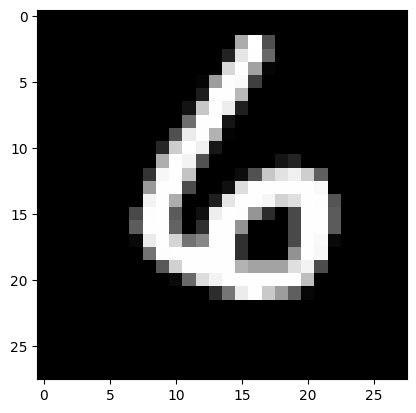

In [1]:
import torchvision.datasets as dts
from torchvision.transforms import ToTensor
import torch
import matplotlib.pyplot as plt
import random
%matplotlib inline

train_set = dts.MNIST(
    root = 'data',
    train = True,                         
    transform = ToTensor(), 
    download = True,            
)
test_set = dts.MNIST(
    root = 'data', 
    train = False, 
    transform = ToTensor()
)
print("DONE")

train_loader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=64, shuffle=False)
data_iterator = iter(train_loader)
images, labels = next(data_iterator)

image = random.choice(images)
plt.imshow(image.numpy().squeeze(), cmap='gray');

In [2]:
print(f"Shape: {image.shape}")

Shape: torch.Size([1, 28, 28])


In [3]:
import torch.nn as nn
import torch.nn.functional as F
class MNistModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super().__init__()
        self.linear = nn.Linear(input_size, hidden_size)
        self.linear2 = nn.Linear(hidden_size, num_classes)

    def forward(self, xb):
        xb = xb.reshape(-1, 784)
        out = self.linear(xb)
        out = F.relu(out)
        out = self.linear2(out)
        return out

model = MNistModel(input_size=784, hidden_size=100, num_classes=10)

images, labels = next(iter(test_loader))

with torch.inference_mode():
    preds = model(images)

print(f"Labels: {labels} | Shape: {labels.shape}")
print(f"Predictions: {preds} | Shape: {preds.shape}")

Labels: tensor([7, 2, 1, 0, 4, 1, 4, 9, 5, 9, 0, 6, 9, 0, 1, 5, 9, 7, 3, 4, 9, 6, 6, 5,
        4, 0, 7, 4, 0, 1, 3, 1, 3, 4, 7, 2, 7, 1, 2, 1, 1, 7, 4, 2, 3, 5, 1, 2,
        4, 4, 6, 3, 5, 5, 6, 0, 4, 1, 9, 5, 7, 8, 9, 3]) | Shape: torch.Size([64])
Predictions: tensor([[-7.4979e-02,  8.2076e-02, -4.8494e-02,  1.6906e-01,  2.6033e-02,
         -5.0038e-02, -4.9221e-02, -1.5589e-02, -8.8482e-02,  1.6818e-01],
        [ 5.7259e-02, -1.1320e-02,  6.1926e-02,  1.0384e-02,  9.3210e-05,
         -1.5085e-01, -1.7388e-01,  1.7571e-01, -6.2951e-02,  1.5906e-01],
        [-8.3356e-02,  4.9162e-02, -3.2821e-02,  7.4252e-02,  3.4510e-02,
         -4.6246e-02, -8.2559e-02,  5.0750e-02,  1.3401e-02,  1.3362e-01],
        [ 4.8357e-02,  3.5590e-02,  2.5907e-02,  1.2076e-01,  2.3641e-02,
         -2.2666e-01, -2.0400e-01,  5.1499e-02, -7.2429e-02,  2.6078e-01],
        [-1.1495e-01,  1.0985e-01,  3.9539e-02,  1.0989e-01, -3.1602e-03,
          4.4616e-02, -9.8125e-02,  7.7772e-02, -3.3756e-02,  6.45

In [4]:
import torch.optim as optim
loss_function = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001)

In [5]:
from tqdm.notebook import tqdm
def train(
        model,
        train_loader,
        test_loader,
        loss_function,
        optimizer,
        epochs=100,
        ):
        epochs_count, train_losses, test_losses = [], [], []
        for epoch in tqdm(range(epochs)):
                model.train()
                back_train_loss = 0
                for images, labels in train_loader:
                        optimizer.zero_grad()
                        output = model(images)
                        loss = loss_function(output, labels)
                        loss.backward()
                        optimizer.step()
                        back_train_loss += loss.item()
                back_test_loss = 0
                accuracy = 0
                model.eval()
                with torch.inference_mode():
                        for images, labels in test_loader:
                                output = model(images)
                                loss = loss_function(output, labels)
                                back_test_loss += loss.item()
                                ps = torch.exp(output)
                                top_p, top_class = ps.topk(1, dim=1)
                                equals = top_class == labels.view(*top_class.shape)
                                accuracy += torch.mean(equals.type(torch.FloatTensor))
                epochs_count.append(epoch+1)
                train_losses.append(back_train_loss/len(train_loader))
                test_losses.append(back_test_loss/len(test_loader))
                print(f"Epoch: {epoch+1}/{epochs} | Training Loss: {back_train_loss/len(train_loader):.2f} | Test Loss: {back_test_loss/len(test_loader):.2f} | Test Accuracy: {accuracy/len(test_loader):.2f}")
        return epochs_count, train_losses, test_losses

def accuracy(model, data_loader):
        from torchmetrics import Accuracy
        acc = Accuracy(task='multiclass', num_classes=10)
        model.eval()
        for X, y in data_loader:
                output = model(X)
                acc.update(output, y)
        return acc.compute()


In [6]:
epochs_count, train_losses, test_losses = train(model, train_loader, test_loader, loss_function, optimizer, epochs=10)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1/10 | Training Loss: 2.21 | Test Loss: 2.10 | Test Accuracy: 0.62
Epoch: 2/10 | Training Loss: 1.97 | Test Loss: 1.82 | Test Accuracy: 0.73
Epoch: 3/10 | Training Loss: 1.67 | Test Loss: 1.50 | Test Accuracy: 0.76
Epoch: 4/10 | Training Loss: 1.37 | Test Loss: 1.21 | Test Accuracy: 0.79
Epoch: 5/10 | Training Loss: 1.12 | Test Loss: 1.00 | Test Accuracy: 0.82
Epoch: 6/10 | Training Loss: 0.94 | Test Loss: 0.85 | Test Accuracy: 0.83
Epoch: 7/10 | Training Loss: 0.82 | Test Loss: 0.75 | Test Accuracy: 0.84
Epoch: 8/10 | Training Loss: 0.73 | Test Loss: 0.67 | Test Accuracy: 0.85
Epoch: 9/10 | Training Loss: 0.67 | Test Loss: 0.62 | Test Accuracy: 0.86
Epoch: 10/10 | Training Loss: 0.62 | Test Loss: 0.57 | Test Accuracy: 0.87


In [7]:
print(f"Train Accuracy: {accuracy(model, train_loader):.2f}")
print(f"Test Accuracy: {accuracy(model, test_loader):.2f}")

Train Accuracy: 0.86
Test Accuracy: 0.87


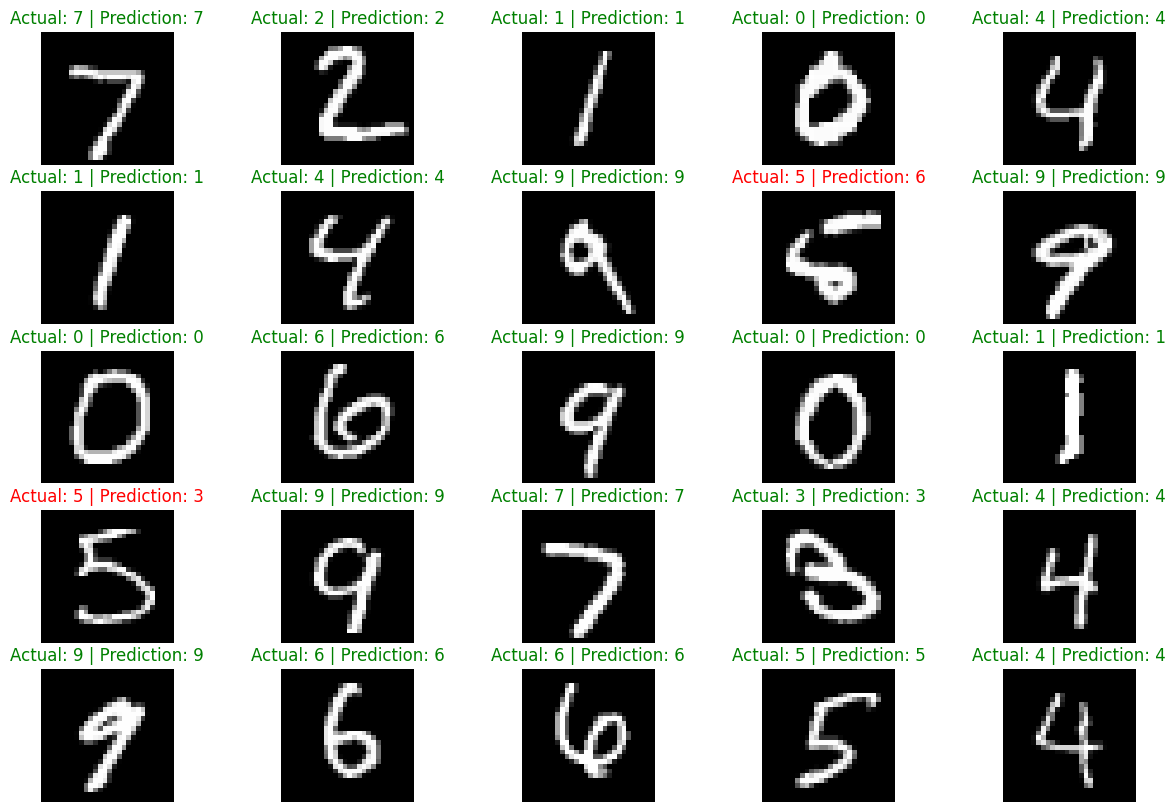

In [8]:
def predict(model, data):
    model.eval()
    with torch.inference_mode():
        output = model(data)
        predicted = torch.softmax(output, dim=1).argmax(dim=1)
        return predicted


images, labels = next(iter(test_loader))

plt.figure(figsize=(15, 10))
for i in range(25):
    image = images[i]
    label = labels[i]
    prediction = predict(model, image).item()
    color = 'green' if label == prediction else 'red'
    plt.subplot(5, 5, i + 1)
    plt.imshow(image.numpy().squeeze(), cmap='gray')
    plt.axis('off')
    plt.title(f'Actual: {label} | Prediction: {prediction}', color=color)
plt.show()
